# Intro<br>
Applying Isolation forest and PCA to all journal entries created by SIEW PENG LAU (suspicious person) to find fraudulant entries. Data called is journal entries<br><br>
New feature selection:
<ul>
    <li>Revenue</li>
    <li>Amt_DocCurrency_NoOfTrailingZeroes_flag</li>
    <li>EndCheck</li>
    <li>OtherCheck</li>
    <li>One-hot encoded Vendor</li>
    <li>One-hot encoded Shipping condition description</li>
    <li>Paid using overpayment</li>
    <li>One-hot encoded Payment Method</li>
    <li>Time from Order to Delivery (Days): sales order create to delivery document date</li>
    <li>Indicator - Unfulfilled PO order: Billing is null but order was placed</li>
</ul>

# GL data

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
from importlib import reload
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

# sys.path.append(r"E:\enyutan\Document\2025 MJE Advanced Analytics\Ishi")
import _00_util_sql
reload(_00_util_sql)
from _00_util_sql import Conn_ODBC
from collections import Counter

In [ ]:
siewdf = pd.read_csv(rf"D:\Shared\Internal Dev - JE ML\Ishi\Results\data_p_ishi_GL_JE_cleaned_SIEWPL", index_col=0)
siewdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18992 entries, 0 to 18991
Data columns (total 64 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   FiscalYear                                  18992 non-null  int64  
 1   AccDocNo                                    18992 non-null  int64  
 2   Dr_Cr                                       18992 non-null  object 
 3   DateOfAccDocEntry                           18992 non-null  object 
 4   DateOfAccDocEntry_and_TimeOfEntry (MYT)     18992 non-null  object 
 5   NoOfLineItemInAccDoc                        18992 non-null  object 
 6   RefKeyForLineItem                           18992 non-null  object 
 7   GL_DESCRIPTION                              18992 non-null  object 
 8   Amt_localCurrencyFormatted                  18992 non-null  object 
 9   Document Type Description                   18992 non-null  object 
 10  Quantity       

In [3]:
df_result = siewdf.copy()

## Overpayment

In [4]:
sql_db=Conn_ODBC(database="JE_ML_2025")

conn=sql_db.odbc_conn_db_pyodbc()

sql_query=f"""
SELECT distinct AccDocNo, DocNoOfClearingDoc from data_ishi_GL_cleaned where DocNoOfClearingDoc in (
Select distinct AccDocNo from data_ishi_GL_cleaned where REPLACE(REPLACE(RefKeyForLineItem, ' ',''), '/','') LIKE '%OPMT%'
)
"""

overpayment_accdocnos = sql_db.odbc_run_sql(conn, sql_query, return_result=True)
conn.close()
overpayment_accdocnos.info()

# 3 mins

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96244 entries, 0 to 96243
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   AccDocNo            96244 non-null  int64
 1   DocNoOfClearingDoc  96244 non-null  int64
dtypes: int64(2)
memory usage: 1.5 MB


In [5]:
sql_db=Conn_ODBC(database="JE_ML_2025")

conn=sql_db.odbc_conn_db_pyodbc()

sql_query=f"""
select DISTINCT AccDocNo as ClearingDocNo, Dr_Cr from data_ishi_GL_cleaned where AccDocNo in --- 2) find the actual clearingdoc entries
(
SELECT DISTINCT DocNoOfClearingDoc FROM data_ishi_GL_cleaned       --- 1) find distinct clearingdoc 
WHERE DocNoOfClearingDoc IS NOT NULL
)
AND REPLACE(REPLACE(RefKeyForLineItem, ' ',''), '/','') LIKE '%OPMT%' order by AccDocNo
"""

clearingdoc_drcr = sql_db.odbc_run_sql(conn, sql_query, return_result=True)
conn.close()
clearingdoc_drcr.info()

# 3 mins

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12703 entries, 0 to 12702
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ClearingDocNo  12703 non-null  int64 
 1   Dr_Cr          12703 non-null  object
dtypes: int64(1), object(1)
memory usage: 198.6+ KB


In [6]:
drcr_grouped = clearingdoc_drcr.groupby('ClearingDocNo')['Dr_Cr'].apply(list).reset_index()
print(drcr_grouped)

       ClearingDocNo Dr_Cr
0         1200026203  [Cr]
1         2200071746  [Cr]
2         2200077977  [Cr]
3         2200078256  [Cr]
4         2200078257  [Cr]
...              ...   ...
12697     2200472884  [Cr]
12698     2200472952  [Cr]
12699     2200472972  [Cr]
12700     2200473406  [Cr]
12701     2200473530  [Cr]

[12702 rows x 2 columns]


In [7]:
merged_df = pd.merge(overpayment_accdocnos, drcr_grouped, left_on='DocNoOfClearingDoc', right_on='ClearingDocNo', how='inner')
merged_df.info()
merged_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96244 entries, 0 to 96243
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   AccDocNo            96244 non-null  int64 
 1   DocNoOfClearingDoc  96244 non-null  int64 
 2   ClearingDocNo       96244 non-null  int64 
 3   Dr_Cr               96244 non-null  object
dtypes: int64(3), object(1)
memory usage: 2.9+ MB


,AccDocNo,DocNoOfClearingDoc,ClearingDocNo,Dr_Cr
0,1200026203,2200301298,2200301298,[Cr]
1,1200026203,1200026203,1200026203,[Cr]
2,1200065227,1200026203,1200026203,[Cr]
3,2000000001,2200259769,2200259769,[Cr]
4,2000000165,2200392307,2200392307,[Cr]


In [8]:
# Step 1: Create a mapping from AccDocNo to DrCr
accdocno_drcr = merged_df.groupby('AccDocNo')['Dr_Cr'].apply(list).reset_index()

accdocno_drcr['Dr_Cr_flat'] = accdocno_drcr['Dr_Cr'].apply(lambda x: [item for sublist in x for item in (sublist if isinstance(sublist, list) else [sublist])])
accdocno_drcr['Dr_Cr_distinct'] = accdocno_drcr['Dr_Cr_flat'].apply(lambda x: ', '.join(sorted(set(x))))

accdocno_drcr[accdocno_drcr['AccDocNo']==2200195655]

# merged_df[merged_df['AccDocNo']==9903896566]
# merged_df[merged_df['AccDocNo']==9903850822]
# merged_df[merged_df['AccDocNo']==9903794623]
# merged_df[merged_df['AccDocNo']==2200201287]
# merged_df[merged_df['AccDocNo']==2200195655]

# Step 2: Add 'overpymt_DrCr' to df_result using the map
# df_result['overpymt_DrCr'] = df_result['AccDocNo'].map(drcr_map)

,AccDocNo,Dr_Cr,Dr_Cr_flat,Dr_Cr_distinct
8660,2200195655,"[[Cr], [Dr, Cr]]","[Cr, Dr, Cr]","Cr, Dr"


In [9]:
#  To indicate if accdocno has overpayment
df_result['overpayment'] = df_result['AccDocNo'].isin(accdocno_drcr['AccDocNo']).astype(int)
df_result['overpayment'].value_counts()

overpayment
0    16786
1     2206
Name: count, dtype: int64

In [10]:
drcr_map = accdocno_drcr.set_index('AccDocNo')['Dr_Cr_distinct'].to_dict()
print(drcr_map[2200195655])
df_result['overpymt_drcr'] = df_result['AccDocNo'].apply(
    lambda x: drcr_map[x] if x in drcr_map else None
)


# df_result[df_result['overpymt_drcr'].notnull()]['overpymt_drcr']

df_result['overpymt_drcr'].value_counts()
# df_result[df_result['AccDocNo']]
# df_result.info()

Cr, Dr


overpymt_drcr
Cr    2206
Name: count, dtype: int64

In [11]:
df_result[df_result['overpayment']==1]

,FiscalYear,AccDocNo,Dr_Cr,DateOfAccDocEntry,DateOfAccDocEntry_and_TimeOfEntry (MYT),NoOfLineItemInAccDoc,RefKeyForLineItem,GL_DESCRIPTION,Amt_localCurrencyFormatted,Document Type Description,...,Cr_Revenue - G\L Account,Dr_Asset - Customer,Dr_Asset - G\L Account,Dr_Cost of Goods Sold (COGS) - G\L Account,Dr_Liability - G\L Account,Dr_Other Costs - G\L Account,Dr_Other Revenue - G\L Account,Dr_Revenue - G\L Account,overpayment,overpymt_drcr
15,2014,9900710547,"['Dr', 'Cr', 'Cr', 'Dr', 'Cr', 'Cr', 'Dr', 'Cr...",2014-01-06,2014-01-07 12:01:07,"['001', '002', '003', '004', '005', '006', '00...","[13012154, None, None, None, None, None, None,...","['Accounts Receivable Control Account', 'Third...","[83140.0, -38310.0, -27372.51, 27372.51, -1708...",Billing Doc.Transfer,...,-83140.0,83140.0,0.0,59224.76,0.0,0.0,0.0,0.00,1,Cr
16,2014,9900712098,"['Dr', 'Cr', 'Cr', 'Dr']",2014-01-07,2014-01-07 17:30:40,"['001', '002', '003', '004']","['PO-10733-INSTALLATIO', None, None, None]","['Accounts Receivable Control Account', 'Warra...","[52000.0, -52000.0, -48000.0, 48000.0]",Billing Doc.Transfer,...,0.0,52000.0,0.0,0.00,0.0,48000.0,0.0,0.00,1,Cr
37,2014,9900722698,"['Dr', 'Cr', 'Cr', 'Dr']",2014-01-05,2014-01-06 09:52:28,"['001', '002', '003', '004']","['M712dn-EMERLY LIM-PU', None, None, None]","['Accounts Receivable Control Account', 'Third...","[7242.0, -7242.0, -390.0, 390.0]",Billing Doc.Transfer,...,-7242.0,7242.0,0.0,0.00,390.0,0.0,0.0,0.00,1,Cr
78,2014,9900730709,"['Dr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr']",2014-01-06,2014-01-07 10:49:00,"['001', '002', '003', '004', '005', '006', '00...","[13012154, None, None, None, None, None, None,...","['Accounts Receivable Control Account', 'Third...","[469.0, -67.0, -67.0, -67.0, -67.0, -67.0, -67...",Billing Doc.Transfer,...,-469.0,469.0,0.0,0.00,0.0,0.0,0.0,0.00,1,Cr
87,2014,9900734855,"['Dr', 'Cr', 'Cr', 'Dr']",2014-01-06,2014-01-07 12:31:50,"['001', '002', '003', '004']","['00729-INSTALLATION-T', None, None, None]","['Accounts Receivable Control Account', 'Warra...","[134815.0, -134815.0, -129000.0, 129000.0]",Billing Doc.Transfer,...,0.0,134815.0,0.0,0.00,0.0,129000.0,0.0,0.00,1,Cr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18736,2019,9912397085,"['Dr', 'Cr']",2019-06-16,2019-06-17 12:43:39,"['001', '002']","[649938, None]","['Accounts Receivable Control Account', 'Third...","[1310.0, -1310.0]",Billing Doc.Transfer,...,-1310.0,1310.0,0.0,0.00,0.0,0.0,0.0,0.00,1,Cr
18754,2019,9912412193,"['Dr', 'Cr', 'Cr']",2019-06-19,2019-06-19 17:48:02,"['001', '002', '003']","[649952, None, None]","['Accounts Receivable Control Account', 'Third...","[3900.0, -3829.0, -71.0]",Billing Doc.Transfer,...,-3900.0,3900.0,0.0,0.00,0.0,0.0,0.0,0.00,1,Cr
18766,2019,9912419003,"['Dr', 'Cr', 'Cr', 'Dr']",2019-06-19,2019-06-19 17:30:19,"['001', '002', '003', '004']","[649972, None, None, None]","['Accounts Receivable Control Account', 'Third...","[5770.0, -5770.0, -906.0, 906.0]",Billing Doc.Transfer,...,-6676.0,5770.0,0.0,0.00,0.0,0.0,0.0,906.00,1,Cr
18797,2019,9912428609,"['Dr', 'Cr', 'Cr', 'Dr', 'Cr', 'Dr', 'Cr', 'Cr']",2019-06-21,2019-06-21 17:25:17,"['001', '002', '003', '004', '005', '006', '00...","[649986, None, None, None, None, None, None, N...","['Accounts Receivable Control Account', 'Third...","[22974.0, -20300.0, -350.0, 350.0, -287.0, 287...",Billing Doc.Transfer,...,-23261.0,22974.0,0.0,0.00,350.0,0.0,0.0,287.00,1,Cr


# ZOTC data

## SQL

In [16]:
-- DECLARE @columns NVARCHAR(MAX);
-- DECLARE @sql NVARCHAR(MAX);

-- IF OBJECT_ID('dbo.ZOTC_MERGED_FINAL', 'U') IS NOT NULL
-- DROP TABLE dbo.ZOTC_MERGED_FINAL;

-- -- Step 1: Get shared columns across all three tables
-- SELECT @columns = STRING_AGG(QUOTENAME(COLUMN_NAME), ', ')
-- FROM (
--     SELECT COLUMN_NAME
--     FROM INFORMATION_SCHEMA.COLUMNS
--     WHERE TABLE_NAME = 'data_ishi_ZOTC_combined'
--     INTERSECT
--     SELECT COLUMN_NAME
--     FROM INFORMATION_SCHEMA.COLUMNS
--     WHERE TABLE_NAME = 'data_ishi_ZOTC_2019'
--     INTERSECT
--     SELECT COLUMN_NAME
--     FROM INFORMATION_SCHEMA.COLUMNS
--     WHERE TABLE_NAME = 'data_ishi_ZOTC_comb_2019'
-- ) AS shared;

-- PRINT @columns;
-- SELECT COUNT(*) AS ColumnCount
-- FROM STRING_SPLIT(@columns, ',');

-- -- Step 2: Build dynamic SQL to create merged result
-- SET @sql = '
-- SELECT ' + @columns + ', source_table
-- INTO ZOTC_MERGED_FINAL
-- FROM (
--     SELECT ' + @columns + ', ''ZOTC_combined'' AS source_table FROM data_ishi_ZOTC_combined
--     UNION 
--     SELECT ' + @columns + ', ''ZOTC_2019'' AS source_table FROM data_ishi_ZOTC_2019
--     UNION
--     SELECT ' + @columns + ', ''ZOTC_comb_2019'' AS source_table FROM data_ishi_ZOTC_comb_2019
-- ) AS combined;';

-- -- Step 3: Execute the SQL
-- EXEC sp_executesql @sql;

-- select count(*) from ZOTC_MERGED_FINAL

SyntaxError: unterminated string literal (detected at line 28) (1744701758.py, line 28)

## Python

In [17]:
##### Import data 
sql_db=Conn_ODBC(database="JE_ML_2025")

conn=sql_db.odbc_conn_db_pyodbc()

sql_query=f"SELECT * FROM [data_ishi_ZOTC_combined]"
zotc = sql_db.odbc_run_sql(conn, sql_query, return_result=True)

conn.close()
# 6 mins

In [18]:
zotc_cols = ['IS Rep','Invoice Number', 'Sold-To Id', 'Customer PO Number', 'Vendor']
zotc_siew = zotc[zotc['IS Rep']=='SIEW PENG LAU'][zotc_cols]
zotc_siew.rename(columns={'Invoice Number': 'AccDocNo'}, inplace=True)
zotc_siew.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41735 entries, 107 to 2820728
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   IS Rep              41735 non-null  object 
 1   AccDocNo            41735 non-null  float64
 2   Sold-To Id          41735 non-null  object 
 3   Customer PO Number  41735 non-null  object 
 4   Vendor              41735 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.9+ MB


In [19]:
zotc_siew['AccDocNo'].nunique()

19346

In [20]:
import pandas as pd

def group_by_accdocno_smart_flatten(df, exclude_cols=None):
    """
    Groups DataFrame by 'AccDocNo', aggregates other columns into lists,
    and flattens to single value if all elements in the list are identical.

    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame with 'AccDocNo' and other columns.
    exclude_cols : list, optional
        Columns to exclude from grouping/aggregation.

    Returns:
    --------
    pd.DataFrame
        One row per AccDocNo, with lists only where multiple distinct values exist.
    """
    
    if 'AccDocNo' not in df.columns:
        raise ValueError("Column 'AccDocNo' not found in DataFrame.")
    
    # Clean: drop rows with missing AccDocNo
    df_clean = df.dropna(subset=['AccDocNo']).copy()
    
    # Determine columns to process
    cols_to_agg = df_clean.columns.tolist()
    if exclude_cols:
        cols_to_agg = [col for col in cols_to_agg if col not in exclude_cols]
    
    # Remove AccDocNo from aggregation list
    feature_cols = [col for col in cols_to_agg if col != 'AccDocNo']
    
    # Define aggregation: collect all as lists
    agg_dict = {col: list for col in feature_cols}
    
    # Group by AccDocNo
    grouped = df_clean.groupby('AccDocNo', as_index=False).agg(agg_dict)
    
    # Decide per column: can we flatten ALL groups?
    for col in feature_cols:
        original_series = grouped[col]

        # Helper to check if a list is uniform (all values equal)
        def is_uniform(val_list):
            if len(val_list) <= 1:
                return True
            try:
                return len(set(val_list)) == 1
            except TypeError:
                # Fallback for unhashable types (dicts, lists, etc.)
                first = val_list[0]
                return all(x == first for x in val_list)

        # Check if ALL groups in this column are uniform
        all_uniform = grouped[col].apply(is_uniform).all()

        if all_uniform:
            # Then we can safely flatten the entire column
            grouped[col] = grouped[col].apply(lambda x: x[0] if len(x) > 0 else None)
        # else: leave as list (already is)


    # # Define a helper function to flatten if all values are the same (only applied row-wise)
    # def flatten_if_uniform(val_list):
    #     if not val_list:
    #         return None
    #     # Get distinct values (handle unhashable like dicts/lists with fallback)
    #     try:
    #         distinct = set(val_list)
    #         if len(distinct) == 1:
    #             return val_list[0]  # return the single unique value
    #         return val_list  # keep as list if multiple distinct values
    #     except TypeError:
    #         # Fallback for unhashable types (e.g., dicts, lists)
    #         for i in range(1, len(val_list)):
    #             if val_list[i] != val_list[0]:
    #                 return val_list  # not uniform, keep list
    #         return val_list[0]  # all equal
    #     except Exception:
    #         return val_list  # fallback: keep list

    # # Apply flattening to each column
    # for col in feature_cols:
    #     grouped[col] = grouped[col].apply(flatten_if_uniform)
    
    return grouped

In [21]:
test = group_by_accdocno_smart_flatten(zotc_siew)  # example: exclude LineItem
test.info()
test.head(6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19346 entries, 0 to 19345
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AccDocNo            19346 non-null  float64
 1   IS Rep              19346 non-null  object 
 2   Sold-To Id          19346 non-null  object 
 3   Customer PO Number  19346 non-null  object 
 4   Vendor              19346 non-null  object 
dtypes: float64(1), object(4)
memory usage: 755.8+ KB


,AccDocNo,IS Rep,Sold-To Id,Customer PO Number,Vendor
0,9.900468e+09,SIEW PENG LAU,APEX COMMUNICATIONS SDN BHD,5821-MRT-PMO-004,"[HP PPS SALES SDN BHD, HP PPS SALES SDN BHD, H..."
1,9.900546e+09,SIEW PENG LAU,CTC GLOBAL SDN BHD,8500008426,[SCHNEIDER ELECTRIC IT MALAYSIA]
2,9.900556e+09,SIEW PENG LAU,CTC GLOBAL SDN BHD,8400061160,[HP PPS SALES SDN BHD]
3,9.900588e+09,SIEW PENG LAU,CD INTEGRATED SDN BHD,13012154,"[ADOBE SYSTEMS SOFTWARE IRELAND, ADOBE SYSTEMS..."
4,9.900634e+09,SIEW PENG LAU,MUTIARA SMART SDN BHD,109404-BSN,[HP PPS SALES SDN BHD]
5,9.900635e+09,SIEW PENG LAU,SISTEM RKK SDN BHD,626733,[ADOBE SYSTEMS SOFTWARE IRELAND]


In [22]:
# Now merge with GL
merged = pd.merge(
    df_result,
    test,
    on='AccDocNo',
    how='left'
)
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18992 entries, 0 to 18991
Data columns (total 70 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   FiscalYear                                  18992 non-null  int64  
 1   AccDocNo                                    18992 non-null  int64  
 2   Dr_Cr                                       18992 non-null  object 
 3   DateOfAccDocEntry                           18992 non-null  object 
 4   DateOfAccDocEntry_and_TimeOfEntry (MYT)     18992 non-null  object 
 5   NoOfLineItemInAccDoc                        18992 non-null  object 
 6   RefKeyForLineItem                           18992 non-null  object 
 7   GL_DESCRIPTION                              18992 non-null  object 
 8   Amt_localCurrencyFormatted                  18992 non-null  object 
 9   Document Type Description                   18992 non-null  object 
 10  Quantity  

In [23]:
merged['Vendor'].value_counts()

Vendor
[HP PPS SALES SDN BHD]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

# ZROS data

## SQL

In [13]:
-- --   Find common columns btw 2 tables

-- DECLARE @columns NVARCHAR(MAX);

-- SELECT @columns = STRING_AGG(QUOTENAME(COLUMN_NAME), ', ')
-- FROM (
--     SELECT COLUMN_NAME
--     FROM INFORMATION_SCHEMA.COLUMNS
--     WHERE TABLE_NAME = 'data_ishi_ZROS'
--     INTERSECT
--     SELECT COLUMN_NAME
--     FROM INFORMATION_SCHEMA.COLUMNS
--     WHERE TABLE_NAME = 'data_ishi_ZROS_2019_2020'
-- ) AS shared;

-- PRINT @columns;
-- SELECT COUNT(*) AS ColumnCount
-- FROM STRING_SPLIT(@columns, ',');

-- --    Merge 2 tables on common cols 

-- DECLARE @sql NVARCHAR(MAX);

-- -- Setting source_table
-- SET @sql = '
-- SELECT * INTO ZROS_merged FROM (
--     SELECT ' + @columns + ', ''ZROS'' AS source_table
--     FROM data_ishi_ZROS

--     UNION ALL

--     SELECT ' + @columns + ', ''ZROS_2019_2020'' AS source_table
--     FROM data_ishi_ZROS_2019_2020
-- ) AS merged_result;
-- ';

SyntaxError: unterminated string literal (detected at line 25) (1132364289.py, line 25)

In [ ]:
-- -- Step 1: Add the new column
-- ALTER TABLE data_ishi_zros_2014
-- ADD source_table VARCHAR(50);

-- -- Step 2: Set the value for all rows
-- UPDATE data_ishi_zros_2014
-- SET source_table = 'ZROS_2014';

-- DECLARE @columns NVARCHAR(MAX);

-- SELECT @columns = STRING_AGG(QUOTENAME(COLUMN_NAME), ', ')
-- FROM (
--     SELECT COLUMN_NAME
--     FROM INFORMATION_SCHEMA.COLUMNS
--     WHERE TABLE_NAME = 'ZROS_MERGED'
--     INTERSECT
--     SELECT COLUMN_NAME
--     FROM INFORMATION_SCHEMA.COLUMNS
--     WHERE TABLE_NAME = 'data_ishi_ZROS_2014'
-- ) AS shared;

-- PRINT @columns;
-- SELECT COUNT(*) AS ColumnCount
-- FROM STRING_SPLIT(@columns, ',');

-- DECLARE @sql NVARCHAR(MAX);
-- -- No source table setting
-- SET @sql = '
-- SELECT ' + @columns + ' FROM ZROS_MERGED
-- UNION ALL
-- SELECT ' + @columns + ' FROM data_ishi_ZROS_2014;';

-- -- To check for shared rows
-- SET @sql = '
-- SELECT '+@columns+' FROM ZROS_MERGED
-- INTERSECT
-- SELECT '+@columns+' FROM data_ishi_ZROS_2014
-- ';

-- -- Execute the dynamic SQL
-- EXEC sp_executesql @sql;

In [ ]:
-- -- Merge Date and Time info together
-- ALTER TABLE zros_merged
-- ADD [Sales Order Create DateTime (Local)] DATETIME2;

-- UPDATE zros_merged
-- SET [Sales Order Create DateTime (Local)] = 
--     DATEADD(SECOND, 
--         DATEDIFF(SECOND, '1900-01-01', CAST([Sales Order Create Time (Local)] AS TIME)), 
--         CAST([Sales Order Create Date (Local)] AS datetime2)
--     );

In [ ]:
-- -- Find "AccDocNos" with partially unfulfilled orders
-- select DISTINCT [BILLING DOCUMENT], [sales document], [Reason for rejection],[Reason for rejection description]
-- FROM ZROS_MERGED WHERE [SALES DOCUMENT] IN (
-- 	-- Find sales that did not have bills (were not charged)
-- 	SELECT distinct [SALES DOCUMENT] FROM ZROS_MERGED WHERE [BILLING DOCUMENT] IS NULL 
-- ) order by [sales document]

-- -- Eg of sales document: 51138086, 51138124, 51138174, 51138290, 51138332, 51138437, 51138448, 51138502
-- -- If Billing Document = NULL, Reason for rejection + desc can also = NULL or others

## Python

In [14]:
##### Import data 
sql_db=Conn_ODBC(database="JE_ML_2025")

conn=sql_db.odbc_conn_db_pyodbc()

sql_query=f"""
select DISTINCT [BILLING DOCUMENT] FROM ZROS_MERGED WHERE [SALES DOCUMENT] IN (
SELECT distinct [SALES DOCUMENT] FROM ZROS_MERGED WHERE [BILLING DOCUMENT] IS NULL
)
"""
#  Get unfulfilled sales documents (order placed but cancelled)
unfulfilled_sales = sql_db.odbc_run_sql(conn, sql_query, return_result=True)

conn.close()
unfulfilled_sales.info()
# 2.5 mins

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130620 entries, 0 to 130619
Data columns (total 1 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   BILLING DOCUMENT  130619 non-null  float64
dtypes: float64(1)
memory usage: 1020.6 KB


In [24]:
#  To indicate if accdocno has unfulfilled PO order
merged['unful_po_order'] = merged['AccDocNo'].isin(unfulfilled_sales['BILLING DOCUMENT']).astype(int)
# merged[merged['unful_po_order']==1]
merged['unful_po_order'].value_counts()

unful_po_order
0    17822
1     1170
Name: count, dtype: int64

In [25]:
##### Import data 
sql_db=Conn_ODBC(database="JE_ML_2025")

conn=sql_db.odbc_conn_db_pyodbc()

sql_query=f"""
SELECT * FROM ZROS_MERGED
"""
#  Get all ZROS data
zros = sql_db.odbc_run_sql(conn, sql_query, return_result=True)

conn.close()
zros.info()
# 22 mins

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213799 entries, 0 to 3213798
Columns: 144 entries, ABC Indicator to Sales Order Create DateTime (Local)
dtypes: float64(20), int64(14), object(110)
memory usage: 3.4+ GB


In [ ]:
zros.columns.tolist()

## Calculating delivery time

In [26]:
zros_cols = ['Sales Document', 'Billing Document', 'Shipping condition description', 
             'Delivery document date',
             'Sales Order Create DateTime (System)',
             'Sales Order Create DateTime (Local)']
zros_selected = zros[zros_cols].copy()
zros_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213799 entries, 0 to 3213798
Data columns (total 6 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   Sales Document                        int64  
 1   Billing Document                      float64
 2   Shipping condition description        object 
 3   Delivery document date                object 
 4   Sales Order Create DateTime (System)  object 
 5   Sales Order Create DateTime (Local)   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 147.1+ MB


In [27]:
zros_selected['Sales Order Create DateTime (Local)'] = pd.to_datetime(zros_selected['Sales Order Create DateTime (Local)'])
zros_selected['Sales Order Create DateTime (System)'] = pd.to_datetime(zros_selected['Sales Order Create DateTime (System)'])
zros_selected['Sales Order Create DateTime (Local)']

0         2015-03-11 22:41:35
1         2015-03-11 22:41:36
2         2015-03-11 22:41:36
3         2015-03-11 22:41:36
4         2015-03-11 20:14:36
                  ...        
3213794   2020-09-24 00:19:35
3213795   2020-09-24 01:43:03
3213796   2020-09-24 01:41:29
3213797   2020-09-25 00:35:33
3213798   2020-09-24 23:01:56
Name: Sales Order Create DateTime (Local), Length: 3213799, dtype: datetime64[ns]

In [28]:
zros_selected['Delivery document date'] = pd.to_datetime(zros_selected['Delivery document date'])
zros_selected['Delivery document date']

0         2015-03-12
1         2015-03-12
2         2015-03-12
3         2015-03-12
4         2015-03-13
             ...    
3213794          NaT
3213795   2020-09-24
3213796   2020-09-25
3213797          NaT
3213798          NaT
Name: Delivery document date, Length: 3213799, dtype: datetime64[ns]

In [29]:
# Using Local Sales Order Create Date
# 2015-03-11 22:41:35
# zros_selected['Sales Order Create DateTime (Local)'].dt.date
zros_selected['Sales Order Create Date (Local)'] = zros_selected['Sales Order Create DateTime (Local)'].dt.date
zros_selected['Sales Order Create Date (Local)'] = pd.to_datetime(zros_selected['Sales Order Create Date (Local)'])
zros_selected['Sales Order Create Date (Local)']

# Calculate difference in days
zros_selected['Order to delivery time (days, local)'] = (zros_selected['Delivery document date'] - zros_selected['Sales Order Create Date (Local)']).dt.days
zros_selected['Order to delivery time (days, local)']

0          1.0
1          1.0
2          1.0
3          1.0
4          2.0
          ... 
3213794    NaN
3213795    0.0
3213796    1.0
3213797    NaN
3213798    NaN
Name: Order to delivery time (days, local), Length: 3213799, dtype: float64

In [30]:
# Using System Sales Order Create Date
# 2015-03-11 22:41:35
# zros_selected['Sales Order Create DateTime (System)'].dt.date
zros_selected['Sales Order Create Date (System)'] = zros_selected['Sales Order Create DateTime (System)'].dt.date
zros_selected['Sales Order Create Date (System)'] = pd.to_datetime(zros_selected['Sales Order Create Date (System)'])
zros_selected['Sales Order Create Date (System)']

# Calculate difference in days
zros_selected['Order to delivery time (days, system)'] = (zros_selected['Delivery document date'] - zros_selected['Sales Order Create Date (System)']).dt.days
zros_selected['Order to delivery time (days, system)']

0          1.0
1          1.0
2          1.0
3          1.0
4          2.0
          ... 
3213794    NaN
3213795    0.0
3213796    1.0
3213797    NaN
3213798    NaN
Name: Order to delivery time (days, system), Length: 3213799, dtype: float64

In [31]:
zros_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213799 entries, 0 to 3213798
Data columns (total 10 columns):
 #   Column                                 Dtype         
---  ------                                 -----         
 0   Sales Document                         int64         
 1   Billing Document                       float64       
 2   Shipping condition description         object        
 3   Delivery document date                 datetime64[ns]
 4   Sales Order Create DateTime (System)   datetime64[ns]
 5   Sales Order Create DateTime (Local)    datetime64[ns]
 6   Sales Order Create Date (Local)        datetime64[ns]
 7   Order to delivery time (days, local)   float64       
 8   Sales Order Create Date (System)       datetime64[ns]
 9   Order to delivery time (days, system)  float64       
dtypes: datetime64[ns](5), float64(3), int64(1), object(1)
memory usage: 245.2+ MB


In [32]:
zros_selected.rename(columns={'Billing Document': 'AccDocNo'}, inplace=True)
# Now merge with GL
df_result = pd.merge(
    merged,
    zros_selected,
    on='AccDocNo',
    how='left'
)
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35779 entries, 0 to 35778
Data columns (total 80 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   FiscalYear                                  35779 non-null  int64         
 1   AccDocNo                                    35779 non-null  int64         
 2   Dr_Cr                                       35779 non-null  object        
 3   DateOfAccDocEntry                           35779 non-null  object        
 4   DateOfAccDocEntry_and_TimeOfEntry (MYT)     35779 non-null  object        
 5   NoOfLineItemInAccDoc                        35779 non-null  object        
 6   RefKeyForLineItem                           35779 non-null  object        
 7   GL_DESCRIPTION                              35779 non-null  object        
 8   Amt_localCurrencyFormatted                  35779 non-null  object        
 9   Docume

In [33]:
df_result[pd.isna(df_result['Sales Order Create Date (System)'])][['AccDocNo','DateOfAccDocEntry']].to_excel(rf'D:\victoriaquek\JE ML 2025\Results\test.xlsx')

# Processing

In [34]:
amounts = [
'Cr_Asset - Asset',
'Cr_Asset - Customer', 
'Cr_Asset - G\\L Account', 
'Cr_Asset - Material',
'Cr_Cost of Goods Sold (COGS) - G\\L Account',
'Cr_Expense (6) - G\\L Account',
'Cr_Liability - G\\L Account', 
'Cr_Liability - Vendor',
'Cr_Other Costs - G\\L Account', 
'Cr_Other Revenue - G\\L Account', 
'Cr_Revenue - G\\L Account', 
'Dr_Asset - Asset', 
'Dr_Asset - Customer', 
'Dr_Asset - G\\L Account', 
'Dr_Asset - Material', 
'Dr_Cost of Goods Sold (COGS) - G\\L Account', 
'Dr_Expense (6) - G\\L Account', 
'Dr_Liability - G\\L Account', 
'Dr_Liability - Vendor', 
'Dr_Other Costs - G\\L Account', 
'Dr_Other Revenue - G\\L Account', 
'Dr_Revenue - G\\L Account'
]

In [35]:
# List to store matches
revenue_list = []

# String to search for
search_term = "revenue"

# Case-insensitive search and add matches to new list
for s in amounts:
    if search_term.lower() in s.lower():
        revenue_list.append(s)

revenue_list

['Cr_Other Revenue - G\\L Account',
 'Cr_Revenue - G\\L Account',
 'Dr_Other Revenue - G\\L Account',
 'Dr_Revenue - G\\L Account']

In [36]:
def calculate_revenue(row, revenue_list):
    total = 0
    for col in revenue_list:
        if col.startswith('Cr_'):
            total -= row[col]
        elif col.startswith('Dr_'):
            total -= row[col]
    return total

# Apply function row-wise
df_result['Revenue'] = df_result.apply(calculate_revenue, axis=1, revenue_list=revenue_list)

In [37]:
import ast

def has_positive_string(x):
    try:
        # Convert string to actual list
        values = ast.literal_eval(x) if isinstance(x, str) else x
        # Check if any string in the list represents a number > 0
        return int(any(float(val) > 0 for val in values))
    except Exception as e:
        return e

df_result['Amt_DocCurrency_NoOfTrailingZeroes_flag'] = df_result['Amt_DocCurrency_NoOfTrailingZeroes'].apply(has_positive_string)

In [38]:
def mark_any_one(df, cols, new_col_name='has_one'):
    df[new_col_name] = df[cols].apply(lambda row: int(1 in row.values), axis=1)
    return df

merge_cols = ['IND_MonthEnd', 'IND_QuarterEnd', 'IND_YearEnd']
mark_any_one(df_result, merge_cols, new_col_name='EndCheck')

merge_cols = ['IND_Weekend', 'IND_PublicHol', 'IND_OutsideWorkHours']
mark_any_one(df_result, merge_cols, new_col_name='OtherCheck')

,FiscalYear,AccDocNo,Dr_Cr,DateOfAccDocEntry,DateOfAccDocEntry_and_TimeOfEntry (MYT),NoOfLineItemInAccDoc,RefKeyForLineItem,GL_DESCRIPTION,Amt_localCurrencyFormatted,Document Type Description,...,Sales Order Create DateTime (System),Sales Order Create DateTime (Local),Sales Order Create Date (Local),"Order to delivery time (days, local)",Sales Order Create Date (System),"Order to delivery time (days, system)",Revenue,Amt_DocCurrency_NoOfTrailingZeroes_flag,EndCheck,OtherCheck
0,2014,9900467949,"['Dr', 'Cr', 'Cr', 'Dr', 'Cr']",2014-01-08,2014-01-08 20:21:18,"['001', '002', '003', '004', '005']","['5821-MRT-PMO-004', None, None, None, None]","['Accounts Receivable Control Account', 'Third...","[3018.0, -2848.0, -284.0, 284.0, -170.0]",Billing Doc.Transfer,...,NaT,NaT,NaT,NaN,NaT,NaN,3018.0,1,0,1
1,2014,9900546273,"['Dr', 'Cr']",2014-01-05,2014-01-06 14:23:14,"['001', '002']","[8500008426, None]","['Accounts Receivable Control Account', 'Third...","[1280.0, -1280.0]",Billing Doc.Transfer,...,NaT,NaT,NaT,NaN,NaT,NaN,1280.0,1,0,0
2,2014,9900555709,"['Dr', 'Cr']",2014-01-06,2014-01-06 21:30:01,"['001', '002']","[8400061160, None]","['Accounts Receivable Control Account', 'Third...","[2128.0, -2128.0]",Billing Doc.Transfer,...,NaT,NaT,NaT,NaN,NaT,NaN,2128.0,0,0,1
3,2014,9900588004,"['Dr', 'Cr', 'Cr', 'Cr']",2014-01-10,2014-01-10 17:54:51,"['001', '002', '003', '004']","[13012154, None, None, None]","['Accounts Receivable Control Account', 'Third...","[201.0, -67.0, -67.0, -67.0]",Billing Doc.Transfer,...,NaT,NaT,NaT,NaN,NaT,NaN,201.0,0,0,0
4,2014,9900634699,"['Dr', 'Cr']",2014-01-02,2014-01-02 19:09:35,"['001', '002']","[626733, None]","['Accounts Receivable Control Account', 'Third...","[66.0, -66.0]",Billing Doc.Transfer,...,NaT,NaT,NaT,NaN,NaT,NaN,66.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35774,2019,9950788382,"['Cr', 'Dr']",2019-06-14,2019-06-14 16:15:56,"['001', '002']","['190240AUT', None]","['Accounts Receivable Control Account', 'Marke...","[-20.0, 20.0]",Bill Doc.Tr - Cr Mem,...,2019-06-13 22:41:56,2019-06-13 22:41:56,2019-06-13,NaN,2019-06-13,NaN,0.0,1,0,0
35775,2019,9950790111,"['Cr', 'Dr']",2019-06-18,2019-06-18 18:15:10,"['001', '002']","['180414HPB(R1)', None]","['Accounts Receivable Control Account', 'Vendo...","[-120.0, 120.0]",Bill Doc.Tr - Cr Mem,...,2019-06-18 01:31:02,2019-06-18 01:31:02,2019-06-18,NaN,2019-06-18,NaN,0.0,1,0,0
35776,2019,9950790176,"['Cr', 'Dr']",2019-06-18,2019-06-18 18:15:51,"['001', '002']","['180417HPW(R1)', None]","['Accounts Receivable Control Account', 'Vendo...","[-150.0, 150.0]",Bill Doc.Tr - Cr Mem,...,2019-06-18 01:04:46,2019-06-18 01:04:46,2019-06-18,NaN,2019-06-18,NaN,0.0,1,0,0
35777,2019,9950790623,"['Cr', 'Dr']",2019-06-18,2019-06-19 10:15:53,"['001', '002']","['180416HPD(R1)', None]","['Accounts Receivable Control Account', 'Vendo...","[-1700.0, 1700.0]",Bill Doc.Tr - Cr Mem,...,2019-06-18 01:49:52,2019-06-18 01:49:52,2019-06-18,NaN,2019-06-18,NaN,0.0,1,0,0


In [39]:
import pandas as pd
import numpy as np
import ast

def expand_list_column_distinct_values(df, column_list):
    """
    For each column in column_list, extract distinct non-NULL values from list entries,
    and create binary indicator columns for each distinct value.
    
    Handles:
      - list, tuple
      - np.ndarray
      - string representations of lists (e.g., "['A', 'B']")
      - scalar values
      - NaN, None, etc.
    
    Parameters:
    df (pd.DataFrame): Input dataframe
    column_list (list): List of column names to process
    
    Returns:
    pd.DataFrame: Original dataframe with binary indicator columns
    """
    result_df = df.copy()
    new_columns = []  # To collect new indicator series

    for col in column_list:
        if col not in df.columns:
            print(f"Warning: Column '{col}' not found in dataframe.")
            continue

        # Helper: Normalize any input to a clean list of non-NA values
        def parse_cell(val):
            # Case 1: Null-like scalar (None, NaN, NaT)
            if val is None or (isinstance(val, float) and pd.isna(val)):
                return []
            if isinstance(val, str) and val.strip() in ('', 'None', 'nan', 'NaN'):
                return []

            # Case 2: NumPy array
            if isinstance(val, np.ndarray):
                # Handle element-wise NA check
                non_na_elements = []
                for v in val.flat:
                    if not (isinstance(v, float) and np.isnan(v)) and v is not None:
                        non_na_elements.append(v)
                return non_na_elements

            # Case 3: List or tuple
            if isinstance(val, (list, tuple)):
                return [v for v in val 
                        if v is not None and not (isinstance(v, float) and pd.isna(v))]

            # Case 4: String that might be a list/tuple
            if isinstance(val, str):
                try:
                    parsed = ast.literal_eval(val)
                    if isinstance(parsed, (list, tuple, np.ndarray)):
                        return [v for v in parsed 
                                if v is not None and not (isinstance(v, float) and pd.isna(v))]
                    # If scalar after eval (e.g. 'hello'), treat as single item
                    if pd.notna(parsed):
                        return [parsed]
                except (ValueError, SyntaxError):
                    # Not a valid Python literal — treat entire string as single value
                    return [val]

            # Case 5: Scalar value (int, str, etc.)
            return [val]

        # Step 1: Collect all distinct non-NULL values across the column
        distinct_values = set()
        for val in df[col]:
            try:
                normalized = parse_cell(val)
                distinct_values.update(normalized)
            except Exception as e:
                continue  # Skip unprocessable values

        # Sort if possible
        try:
            distinct_values = sorted(distinct_values)
        except TypeError:
            distinct_values = sorted(distinct_values, key=str)

        # Step 2: Create binary indicators for each distinct value
        for value in distinct_values:
            new_col_name = f"{col}_{value}"

            # Use .apply() with safe membership check
            indicator = df[col].apply(
                lambda cell, target=value: 1 if target in parse_cell(cell) else 0
            )

            new_columns.append(pd.Series(indicator, name=new_col_name, index=df.index))

    # Step 3: Concatenate all new columns at once to avoid fragmentation
    if new_columns:
        indicators_df = pd.concat(new_columns, axis=1)
        result_df = pd.concat([result_df, indicators_df], axis=1)

    # Return clean, defragmented copy
    return result_df.copy()

In [40]:
one_cols = ['PaymentMethod', 'Vendor']
df_result_1 = expand_list_column_distinct_values(df_result, one_cols)
df_result_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35779 entries, 0 to 35778
Columns: 197 entries, FiscalYear to Vendor_ZYXEL (M) SDN BHD
dtypes: datetime64[ns](5), float64(20), int64(129), object(43)
memory usage: 53.8+ MB


In [41]:
# Checking PaymentMethod one hot encoding
# Identify rows with at least one non-null value in the list
# Apply logic to parse string and check for non-null values
has_non_null = df_result['PaymentMethod'].apply(
    lambda x: (
        isinstance(x, str) and
        any(pd.notnull(item) for item in ast.literal_eval(x))
    )
)

# Get the index of matching rows
matching_indices = df_result.index[has_non_null].tolist()
print(matching_indices)

pay_cols = [col for col in df_result_1.columns if col.startswith('PaymentMethod_')]
pay_cols = ['PaymentMethod'] + pay_cols
df_result_1.iloc[608][pay_cols]

[608, 611, 791, 845, 871, 888, 933, 1204, 1205, 1352, 1361, 1380, 1392, 1407, 1504, 1534, 1564, 1567, 1591, 1645, 1696, 1811, 1812, 1831, 1879, 1882, 1899, 1900, 1925, 1943, 1991, 2051, 2077, 2133, 2240, 2394, 2400, 2420, 2425, 2465, 2469, 2545, 2577, 2657, 2825, 2826, 2827, 2828, 2855, 2906, 2961, 2982, 3028, 3029, 3046, 3072, 3089, 3090, 3101, 3107, 3111, 3112, 3113, 3115, 3116, 3117, 3118, 3120, 3126, 3127, 3130, 3131, 3134, 3137, 3138, 3144, 3145, 3146, 3147, 3148, 3149, 3165, 3220, 3359, 3360, 3376, 3385, 3406, 3511, 3558, 3649, 3659, 3685, 3693, 3718, 3738, 3740, 3795, 3837, 3883, 3932, 3952, 3989, 4005, 4026, 4039, 4042, 4043, 4044, 4045, 4048, 4049, 4050, 4051, 4424, 4425, 4426, 4427, 4428, 4429, 4430, 4431, 4432, 4433, 4434, 4435, 4436, 4437, 4438, 4439, 4440, 4441, 4442, 4443, 4444, 4445, 4446, 4447, 4448, 4449, 4450, 4451, 4452, 4453, 4454, 4455, 4456, 4457, 4458, 4459, 4460, 4461, 4462, 4463, 4464, 4465, 4615, 4616, 4617, 4820, 4821, 4822, 4823, 4824, 4825, 4826, 4827, 5934

PaymentMethod      ['L', None, None, None, None, None, None, None...
PaymentMethod_1                                                    0
PaymentMethod_L                                                    1
Name: 608, dtype: object

In [42]:
# Checking vendor cols are correct
vendor_cols = [col for col in df_result_1.columns if col.startswith('Vendor_')]
# print(vendor_cols)
vendor_cols = ['Vendor', 'AccDocNo'] + vendor_cols

df_result_1.iloc[[0]][vendor_cols]
# HP PPS SALES SDN BHD

df_result_1.iloc[[35]][vendor_cols]
# ['TOSHIBA SINGAPORE PTE LTD', 'TELE DYNAMICS SDN BHD', 'HP PPS SALES SDN BHD', 'MICROSOFT REGIONAL SALES PTE.']

,Vendor,AccDocNo,"Vendor_A10 Networks, Inc",Vendor_ACAD SYSTEMS SDN BHD,Vendor_ACER SALES AND SERVICES SDN BH,Vendor_ACRONIS ASIA PTE LTD,Vendor_ADOBE SYSTEMS SOFTWARE IRELAND,Vendor_ADVANCENET TECHNOLOGY SDN BHD,Vendor_APRICOT SYSTEMS SDN BHD,Vendor_ARBOR NETWORKS UK LTD,...,Vendor_TREND MICRO AUSTRALIA PTY LTD,Vendor_UES E-SOLUTIONS SDN BHD,Vendor_VCE TECHNOLOGY SOLUTIONS LTD,Vendor_VEEAM PTY LTD,"Vendor_VELOCLOUD NETWORKS,LLC",Vendor_VERITAS STORAGE (SINGAPORE) PT,Vendor_VMWARE INTERNATONAL UNLIMITED,"Vendor_VMWARE,INTERNATONAL LIMITED",Vendor_ZEBRA TECHNOLOGIES ASIA PACIFI,Vendor_ZYXEL (M) SDN BHD
35,"[TOSHIBA SINGAPORE PTE LTD, TELE DYNAMICS SDN ...",9900719801,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
to_encode = ['Shipping condition description']
encoder = OneHotEncoder(sparse_output=False)
encoded_array = encoder.fit_transform(df_result[to_encode])

# Convert to DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(to_encode))

# Combine with original DataFrame
df_result_2 = pd.concat([df_result_1, encoded_df], axis=1)

In [44]:
# Checking shipping condition desciption one hot encoding
# print(df_result[df_result['Shipping condition description'].notna()].index)
ship_cols = [col for col in df_result_2.columns if col.startswith('Shipping condition description_')]
# print(ship_cols)

ship_cols=['Shipping condition description']+ship_cols
print(ship_cols)

df_result_2.iloc[[3851]][ship_cols]

['Shipping condition description', 'Shipping condition description_No Transportation', 'Shipping condition description_PRCL - Std AM', 'Shipping condition description_RMA / Call Tags', 'Shipping condition description_Standard Air', 'Shipping condition description_Standard Grnd Parcel', 'Shipping condition description_Std HWA - Deferred', 'Shipping condition description_Will Call', 'Shipping condition description_nan']


,Shipping condition description,Shipping condition description_No Transportation,Shipping condition description_PRCL - Std AM,Shipping condition description_RMA / Call Tags,Shipping condition description_Standard Air,Shipping condition description_Standard Grnd Parcel,Shipping condition description_Std HWA - Deferred,Shipping condition description_Will Call,Shipping condition description_nan
3851,Standard Grnd Parcel,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Feature selection

In [45]:
vendor_cols = [col for col in df_result_2.columns if col.startswith('Vendor_')]
print(len(vendor_cols))
print(vendor_cols)

pay_cols = [col for col in df_result_2.columns if col.startswith('PaymentMethod_')]
print(len(pay_cols))
print(pay_cols)

ship_cols = [col for col in df_result_2.columns if col.startswith('Shipping condition description_')]
print(len(ship_cols))
print(ship_cols)

111
['Vendor_A10 Networks, Inc', 'Vendor_ACAD SYSTEMS SDN BHD', 'Vendor_ACER SALES AND SERVICES SDN BH', 'Vendor_ACRONIS ASIA PTE LTD', 'Vendor_ADOBE SYSTEMS SOFTWARE IRELAND', 'Vendor_ADVANCENET TECHNOLOGY SDN BHD', 'Vendor_APRICOT SYSTEMS SDN BHD', 'Vendor_ARBOR NETWORKS UK LTD', 'Vendor_ASSOCIATE INNOVATION SDN BHD', 'Vendor_ASUS GLOBAL PTE LTD', 'Vendor_AUTODESK ASIA PTE LTD', 'Vendor_AXERRA SYSTEMS SDN BHD', 'Vendor_AXIS COMMUNICATIONS (S) PTE LT', 'Vendor_BARRACUDA NETWORK INC', 'Vendor_BASELINE SYSTEMS', 'Vendor_BENQ SERVICE & MARKETING (M) S', 'Vendor_BINET SYSTEMS SDN BHD', 'Vendor_BRIDGENET SOLUTIONS SDN BHD', 'Vendor_BROCADE COMMUNICATIONS SWITZER', 'Vendor_BROTHER INTERNATIONAL (M) SDN', 'Vendor_BitTitan, Inc.', 'Vendor_CANON MARKETING (M) SDN BHD', 'Vendor_CESR RESOURCES SDN BHD', 'Vendor_CISCO INTERNATIONAL LIMITED', 'Vendor_CISCO SYSTEMS INTERNATIONAL BV', 'Vendor_D-LINK INTERNATIONAL PTE LTD', 'Vendor_DATASONIC CORPORATION SDN BHD', 'Vendor_DELL GLOBAL BUSINESS CENTER S

In [48]:
feature_cols = [
    'Revenue', 
    'Amt_DocCurrency_NoOfTrailingZeroes_flag', 
    'EndCheck', 
    'OtherCheck', 
    'Order to delivery time (days, local)', 
    'overpayment', 
    'overpymt_drcr', # DR/CR
    'unful_po_order',
]

feature_cols = feature_cols+pay_cols+vendor_cols+ship_cols

In [49]:
df_numeric = df_result_2[feature_cols].copy()
df_numeric.columns.to_list()

['Revenue',
 'Amt_DocCurrency_NoOfTrailingZeroes_flag',
 'EndCheck',
 'OtherCheck',
 'Order to delivery time (days, local)',
 'overpayment',
 'overpymt_drcr',
 'unful_po_order',
 'PaymentMethod_1',
 'PaymentMethod_L',
 'Vendor_A10 Networks, Inc',
 'Vendor_ACAD SYSTEMS SDN BHD',
 'Vendor_ACER SALES AND SERVICES SDN BH',
 'Vendor_ACRONIS ASIA PTE LTD',
 'Vendor_ADOBE SYSTEMS SOFTWARE IRELAND',
 'Vendor_ADVANCENET TECHNOLOGY SDN BHD',
 'Vendor_APRICOT SYSTEMS SDN BHD',
 'Vendor_ARBOR NETWORKS UK LTD',
 'Vendor_ASSOCIATE INNOVATION SDN BHD',
 'Vendor_ASUS GLOBAL PTE LTD',
 'Vendor_AUTODESK ASIA PTE LTD',
 'Vendor_AXERRA SYSTEMS SDN BHD',
 'Vendor_AXIS COMMUNICATIONS (S) PTE LT',
 'Vendor_BARRACUDA NETWORK INC',
 'Vendor_BASELINE SYSTEMS',
 'Vendor_BENQ SERVICE & MARKETING (M) S',
 'Vendor_BINET SYSTEMS SDN BHD',
 'Vendor_BRIDGENET SOLUTIONS SDN BHD',
 'Vendor_BROCADE COMMUNICATIONS SWITZER',
 'Vendor_BROTHER INTERNATIONAL (M) SDN',
 'Vendor_BitTitan, Inc.',
 'Vendor_CANON MARKETING (M) SDN

In [73]:
from sklearn.preprocessing import LabelEncoder

if 'overpymt_drcr' in df_numeric:
    label_encoder = LabelEncoder()
    df_numeric['overpymt_drcr_encocded']=label_encoder.fit_transform(df_numeric['overpymt_drcr'])
    print("Classes:", label_encoder.classes_)
    df_numeric.drop(columns=['overpymt_drcr'],inplace=True)

print(df_numeric.columns)
print(df_numeric['overpymt_drcr_encocded'].value_counts())
df_numeric['overpayment'].value_counts()

Index(['Revenue', 'Amt_DocCurrency_NoOfTrailingZeroes_flag', 'EndCheck',
       'OtherCheck', 'Order to delivery time (days, local)', 'overpayment',
       'unful_po_order', 'PaymentMethod_1', 'PaymentMethod_L',
       'Vendor_A10 Networks, Inc',
       ...
       'Vendor_ZYXEL (M) SDN BHD',
       'Shipping condition description_No Transportation',
       'Shipping condition description_PRCL - Std AM',
       'Shipping condition description_RMA / Call Tags',
       'Shipping condition description_Standard Air',
       'Shipping condition description_Standard Grnd Parcel',
       'Shipping condition description_Std HWA - Deferred',
       'Shipping condition description_Will Call',
       'Shipping condition description_nan', 'overpymt_drcr_encocded'],
      dtype='object', length=129)
overpymt_drcr_encocded
1    30781
0     4998
Name: count, dtype: int64


overpayment
0    30781
1     4998
Name: count, dtype: int64

In [74]:
# Check for NaNs
print("Number of NaN values:", np.isnan(df_numeric).sum().sum())

# Check for Infs
print("Number of Inf values:", np.isinf(df_numeric).sum().sum())

# Find columns with at least one NaN
nan_columns = df_numeric.columns[df_numeric.isna().any()].tolist()
print("Columns with NaN values:", nan_columns)

# Get unique non-null values from each NaN column
unique_data_in_nan_columns = {
    col: df_numeric[col].dropna().unique().tolist()
    for col in nan_columns
}

# Display the results
for col, unique_vals in unique_data_in_nan_columns.items():
    print(f"Column: {col}")
    print(f"Unique values (excluding NaN): {unique_vals}\n")

Number of NaN values: 0
Number of Inf values: 0
Columns with NaN values: []


In [75]:
df_numeric=df_numeric.fillna(0)

# Isolation Forest

## Functions

In [76]:
from typing import Dict, Optional

def detect_anomalies_isolation_forest(
    data,
    contamination: str = 'auto',
    n_estimators: int = 100,
    max_samples: str = 'auto',
    random_state: Optional[int] = 42,
    visualize: bool = False
) -> Dict:
    """
    Detect anomalies in a dataset using Isolation Forest without knowing true anomalies.
    
    Parameters:
    -----------
    data : pd.DataFrame or np.ndarray
        Input dataset
    contamination : str or float, default='auto'
        Expected proportion of outliers in the data
    n_estimators : int, default=100
        Number of base estimators in the ensemble
    max_samples : str or int, default='auto'
        Number of samples to draw from X to train each base estimator
    random_state : int, optional
        Random state for reproducibility
    scale_data : bool, default=True
        Whether to standardize the features
    return_scores : bool, default=True
        Whether to return anomaly scores
    visualize : bool, default=False
        Whether to create visualization plots
    
    Returns:
    --------
    dict : Dictionary containing results with keys:
        - 'anomaly_labels': 1 for normal, -1 for anomaly
        - 'anomaly_scores': Anomaly scores (lower = more anomalous)
        - 'anomaly_indices': Indices of detected anomalies
        - 'n_anomalies': Number of detected anomalies
        - 'contamination_rate': Estimated contamination rate
        - 'model': Fitted Isolation Forest model
    """
    
    X = data.values

    # Initialize and fit Isolation Forest
    iso_forest = IsolationForest(
        contamination=contamination,
        n_estimators=n_estimators,
        max_samples=max_samples,
        random_state=random_state,
        n_jobs=-1
    )
    
    anomaly_labels = iso_forest.fit_predict(X)
    anomaly_scores = iso_forest.decision_function(X)
    
    # Get anomaly indices
    anomaly_indices = np.where(anomaly_labels == -1)[0]
    n_anomalies = len(anomaly_indices)
    
    # Calculate actual contamination rate
    # contamination_rate = n_anomalies / len(X_scaled)
    contamination_rate = n_anomalies / len(X)
    
    # Create a DataFrame with anomaly results aligned to original index
    results_df = pd.DataFrame({
        'is_anomaly': anomaly_labels == -1,
        'anomaly_score': anomaly_scores,
        'anomaly_label': anomaly_labels  # -1 = anomaly, 1 = normal
    }, index=data.index)
    
    # Join back to original DataFrame
    enriched_df = data.copy()
    enriched_df = enriched_df.join(results_df)

    # Prepare results
    results = {
        'new_df': enriched_df,
        'anomaly_labels': anomaly_labels,
        'anomaly_scores': anomaly_scores,
        'anomaly_indices': anomaly_indices,
        'n_anomalies': n_anomalies,
        'contamination_rate': contamination_rate,
        'model': iso_forest
    }
    
    # Add original data info
    results['anomaly_data'] = data.iloc[anomaly_indices] if isinstance(data, pd.DataFrame) else None
    
    # Visualization
    if visualize:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Anomaly score distribution
        axes[0,0].hist(anomaly_scores, bins=50, alpha=0.7, color='skyblue')
        axes[0,0].axvline(x=0, color='red', linestyle='--', label='Decision boundary')
        axes[0,0].set_xlabel('Anomaly Score')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].set_title('Distribution of Anomaly Scores')
        axes[0,0].legend()
        
        # 2. Anomaly labels
        axes[0,1].scatter(range(len(anomaly_labels)), anomaly_labels, c=anomaly_labels, cmap='RdYlBu', alpha=0.6)
        axes[0,1].set_xlabel('Sample Index')
        axes[0,1].set_ylabel('Anomaly Label')
        axes[0,1].set_title('Anomaly Detection Results')
        axes[0,1].set_yticks([-1, 1])
        axes[0,1].set_yticklabels(['Anomaly', 'Normal'])
        
        # 3. Top 2 principal components (if > 2 features)
        if X.shape[1] > 1:
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            X_pca = pca.fit_transform(X)
            
            scatter = axes[1,0].scatter(X_pca[:, 0], X_pca[:, 1], c=anomaly_labels, 
                                      cmap='RdYlBu', alpha=0.6, s=50)
            axes[1,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
            axes[1,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
            axes[1,0].set_title('Anomalies in 2D PCA Space')
            plt.colorbar(scatter, ax=axes[1,0])
        else:
            axes[1,0].text(0.5, 0.5, 'Not enough features\nfor PCA visualization', 
                          ha='center', va='center', transform=axes[1,0].transAxes)
            axes[1,0].set_title('PCA Visualization')
        
        # 4. Anomaly score vs sample index
        axes[1,1].scatter(range(len(anomaly_scores)), anomaly_scores, 
                         c=anomaly_labels, cmap='RdYlBu', alpha=0.6)
        axes[1,1].axhline(y=0, color='red', linestyle='--')
        axes[1,1].set_xlabel('Sample Index')
        axes[1,1].set_ylabel('Anomaly Score')
        axes[1,1].set_title('Anomaly Scores by Sample Index')
        
        plt.tight_layout()
        plt.show()
    
    # Print summary
    print(f"Isolation Forest Anomaly Detection Results:")
    print(f"Total samples: {len(X)}")
    print(f"Detected anomalies: {n_anomalies}")
    print(f"Contamination rate: {contamination_rate:.3f}")
    print(f"Anomaly score range: [{anomaly_scores.min():.3f}, {anomaly_scores.max():.3f}]")
    
    if n_anomalies > 0:
        print(f"Top 5 most anomalous samples (lowest scores):")
        top_anomalies = np.argsort(anomaly_scores)[:5]
        for i, idx in enumerate(top_anomalies):
            print(f"  #{i+1}: Sample {idx}, Score: {anomaly_scores[idx]:.3f}")
    
    return results

In [77]:
def add_anomaly_columns_to_original_df(data_original, anomalies_df):
    """
    Adds only the new anomaly columns to the original DataFrame,
    skipping any that already exist.

    Parameters:
        data_original (pd.DataFrame): Original DataFrame (e.g., data_22)
        anomalies_df (pd.DataFrame): DataFrame with predicted anomaly results

    Returns:
        pd.DataFrame: Updated DataFrame with only the new anomaly columns added
    """
    # List of expected anomaly-related columns
    new_cols = ['anomaly_score', 'is_anomaly']

    # Check which columns are missing in data_original
    cols_to_add = [col for col in new_cols if col not in data_original.columns]

    if not cols_to_add:
        print("\n✅ All anomaly columns already exist. No new columns to add.")
        return data_original

    print(f"\n➕ Adding the following columns to the original DataFrame: {cols_to_add}")

    # Join only the missing columns
    data_with_anomalies = data_original.join(anomalies_df[cols_to_add])

    return data_with_anomalies

## Apply

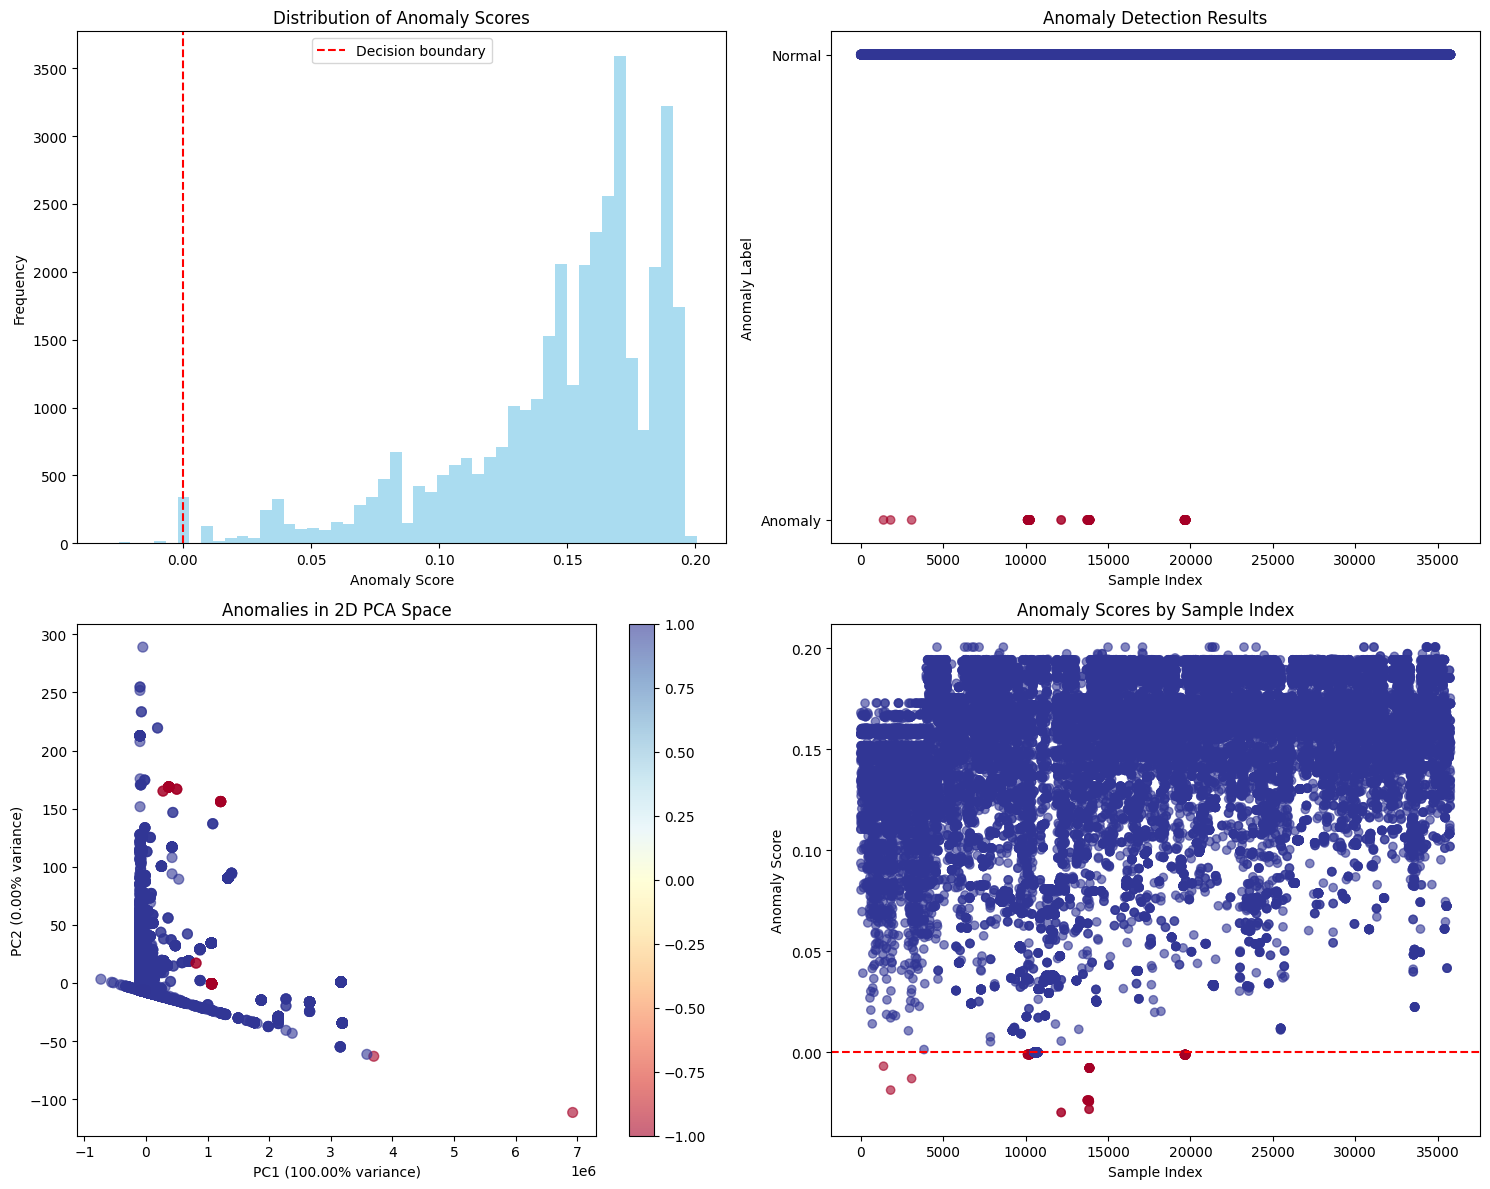

Isolation Forest Anomaly Detection Results:
Total samples: 35779
Detected anomalies: 138
Contamination rate: 0.004
Anomaly score range: [-0.030, 0.200]
Top 5 most anomalous samples (lowest scores):
  #1: Sample 12159, Score: -0.030
  #2: Sample 12158, Score: -0.030
  #3: Sample 13852, Score: -0.028
  #4: Sample 13853, Score: -0.028
  #5: Sample 13860, Score: -0.024


In [78]:
# Apply the function
results = detect_anomalies_isolation_forest(
    df_numeric,
    contamination=0.01,
    n_estimators=50,
    visualize=True
)

In [79]:
final_df = results['new_df']
final_df.columns.to_list()

['Revenue',
 'Amt_DocCurrency_NoOfTrailingZeroes_flag',
 'EndCheck',
 'OtherCheck',
 'Order to delivery time (days, local)',
 'overpayment',
 'unful_po_order',
 'PaymentMethod_1',
 'PaymentMethod_L',
 'Vendor_A10 Networks, Inc',
 'Vendor_ACAD SYSTEMS SDN BHD',
 'Vendor_ACER SALES AND SERVICES SDN BH',
 'Vendor_ACRONIS ASIA PTE LTD',
 'Vendor_ADOBE SYSTEMS SOFTWARE IRELAND',
 'Vendor_ADVANCENET TECHNOLOGY SDN BHD',
 'Vendor_APRICOT SYSTEMS SDN BHD',
 'Vendor_ARBOR NETWORKS UK LTD',
 'Vendor_ASSOCIATE INNOVATION SDN BHD',
 'Vendor_ASUS GLOBAL PTE LTD',
 'Vendor_AUTODESK ASIA PTE LTD',
 'Vendor_AXERRA SYSTEMS SDN BHD',
 'Vendor_AXIS COMMUNICATIONS (S) PTE LT',
 'Vendor_BARRACUDA NETWORK INC',
 'Vendor_BASELINE SYSTEMS',
 'Vendor_BENQ SERVICE & MARKETING (M) S',
 'Vendor_BINET SYSTEMS SDN BHD',
 'Vendor_BRIDGENET SOLUTIONS SDN BHD',
 'Vendor_BROCADE COMMUNICATIONS SWITZER',
 'Vendor_BROTHER INTERNATIONAL (M) SDN',
 'Vendor_BitTitan, Inc.',
 'Vendor_CANON MARKETING (M) SDN BHD',
 'Vendor_CE

In [86]:
# Add only the missing anomaly columns to original data_22
result_df = add_anomaly_columns_to_original_df(df_result_2, final_df)
result_df.info()
print('')
print(f'No. of anomalies: {(result_df['is_anomaly']==1).sum()}')


➕ Adding the following columns to the original DataFrame: ['anomaly_score', 'is_anomaly']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35779 entries, 0 to 35778
Columns: 207 entries, FiscalYear to is_anomaly
dtypes: bool(1), datetime64[ns](5), float64(29), int64(129), object(43)
memory usage: 56.3+ MB

No. of anomalies: 138


## Explaining

### LIME

In [87]:
def lime_global_feature_importance(lime_explanations: dict) -> pd.DataFrame:
    """
    Aggregate LIME explanations to compute global feature importance.
    
    Parameters:
    -----------
    lime_explanations : dict
        Output from explain_anomalies_with_lime()
    
    Returns:
    --------
    pd.DataFrame: Sorted feature importance (mean absolute weight)
    """
    feature_contributions = []

    for idx, exp_data in lime_explanations.items():
        exp = exp_data['explanation']
        # Get feature, weight pairs
        lime_list = exp.as_list(label=0)  # Label 0 = 'Anomaly' (since -1 is anomaly)
        
        for feature, weight in lime_list:
            # Parse feature name (e.g., "Amount > 1000" -> "Amount")
            base_feature = feature.split(" ")[0]  # Crude but works for simple cases
            feature_contributions.append({
                'feature': base_feature,
                'abs_contribution': abs(weight),
                'contribution': weight,
                'sample_idx': idx
            })
    
    # Create DataFrame
    contrib_df = pd.DataFrame(feature_contributions)
    
    # Aggregate: mean absolute contribution (global importance)
    global_importance = (
        contrib_df.groupby('feature')['abs_contribution']
        .agg(['mean', 'std', 'count'])
        .rename(columns={'mean': 'mean_abs_contribution', 'std': 'std_dev', 'count': 'frequency'})
        .sort_values(by='mean_abs_contribution', ascending=False)
    )
    
    return global_importance

In [88]:
from lime import lime_tabular
import numpy as np

def explain_anomalies_with_lime(
    iso_forest_model,
    data: pd.DataFrame,
    anomaly_indices: np.ndarray,
    num_samples: int = 5,
    local_analysis_size: int = 5000
) -> dict:
    """
    Use LIME to explain top anomalous instances from Isolation Forest.
    
    Parameters:
    -----------
    iso_forest_model : IsolationForest
        Trained IsolationForest model
    data : pd.DataFrame
        Original input data (with index preserved)
    anomaly_indices : array
        Indices of detected anomalies
    num_samples : int
        Number of top anomalies to explain
    local_analysis_size : int
        Max number of samples to use for LIME training (for performance)

    Returns:
    --------
    dict: Mapping of sample index to LIME explanation object and feature weights
    """
    # Prepare LIME explainer
    X_train = data.values

    # Limit training data size for performance
    if X_train.shape[0] > local_analysis_size:
        np.random.seed(42)
        subset_idx = np.random.choice(X_train.shape[0], local_analysis_size, replace=False)
        X_train_sample = X_train[subset_idx]
    else:
        X_train_sample = X_train

    explainer = lime_tabular.LimeTabularExplainer(
        X_train_sample,
        feature_names=data.columns,
        class_names=['Anomaly', 'Normal'],
        mode='classification',
        random_state=42,
        discretize_continuous=False
    )

    # Custom prediction function for Isolation Forest
    def iso_forest_predict_proba(X):
        # IsolationForest outputs -1 (anomaly) or 1 (normal)
        # We want probability-like output: [P(anomaly), P(normal)]
        labels = iso_forest_model.predict(X)
        probs = np.zeros((X.shape[0], 2))
        # Assign higher prob to predicted class
        for i, label in enumerate(labels):
            if label == -1:
                probs[i] = [0.9, 0.1]  # high prob for anomaly
            else:
                probs[i] = [0.1, 0.9]  # high prob for normal
        return probs

    explanations = {}
    top_anomaly_indices = anomaly_indices[:num_samples]

    for idx in top_anomaly_indices:
        exp = explainer.explain_instance(
            data.iloc[idx].values,
            iso_forest_predict_proba,
            num_features=len(data.columns),
            top_labels=1
        )
        explanations[idx] = {
            'explanation': exp,
            'predicted': iso_forest_model.predict([data.iloc[idx].values])[0],
            'score': iso_forest_model.decision_function([data.iloc[idx].values])[0]
        }

    return explanations

In [89]:
def plot_lime_explanations(lime_explanations: dict, data: pd.DataFrame):
    """
    Plot LIME explanations for each anomalous sample.
    
    Parameters:
    -----------
    lime_explanations : dict
        Output from explain_anomalies_with_lime
    data : pd.DataFrame
        Original data to show actual values
    """
    import matplotlib.pyplot as plt

    for idx, exp_data in lime_explanations.items():
        exp = exp_data['explanation']
        predicted = exp_data['predicted']
        score = exp_data['score']

        # Extract feature weights from LIME
        lime_list = exp.as_list(label=1 if predicted == 1 else 0)  # 0 = anomaly
        features, weights = zip(*[(f, w) for f, w in lime_list])

        colors = ['red' if w < 0 else 'green' for w in weights]  # red = pro-anomaly, green = pro-normal

        plt.figure(figsize=(8, 0.5 + 0.3 * len(features)))
        bars = plt.barh(features, weights, color=colors, edgecolor='black', alpha=0.7)
        plt.xlabel("Contribution to 'Normal' Prediction")
        plt.title(f"LIME Explanation: Sample {idx} (AccDocNo: {data.index[idx]})\n"
                  f"Anomaly Score: {score:.3f}, Predicted: {'Anomaly' if predicted == -1 else 'Normal'}")

        # Add value labels
        for bar, weight in zip(bars, weights):
            plt.text(bar.get_width() + (max(weights) * 0.02), bar.get_y() + bar.get_height()/2,
                     f'{weight:.3f}', va='center', fontsize=9)

        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

In [90]:
def plot_lime_global_importance(global_importance: pd.DataFrame, top_n: int = 10):
    """
    Plot global feature importance from LIME.
    """
    import matplotlib.pyplot as plt

    top_features = global_importance.head(top_n)

    plt.figure(figsize=(10, 6))
    bars = plt.barh(top_features.index, top_features['mean_abs_contribution'], 
                    xerr=top_features['std_dev'], color='skyblue', edgecolor='black', alpha=0.8)
    plt.xlabel("Mean |LIME Weight| (Impact on Anomaly Decision)")
    plt.title(f"Top {top_n} Features Driving Anomalies (LIME Aggregated)")
    plt.gca().invert_yaxis()

    # Add value labels
    for bar, row in zip(bars, top_features.itertuples()):
        plt.text(bar.get_width() + top_features['mean_abs_contribution'].max() * 0.01,
                 bar.get_y() + bar.get_height()/2, f'{row.mean_abs_contribution:.3f}',
                 va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

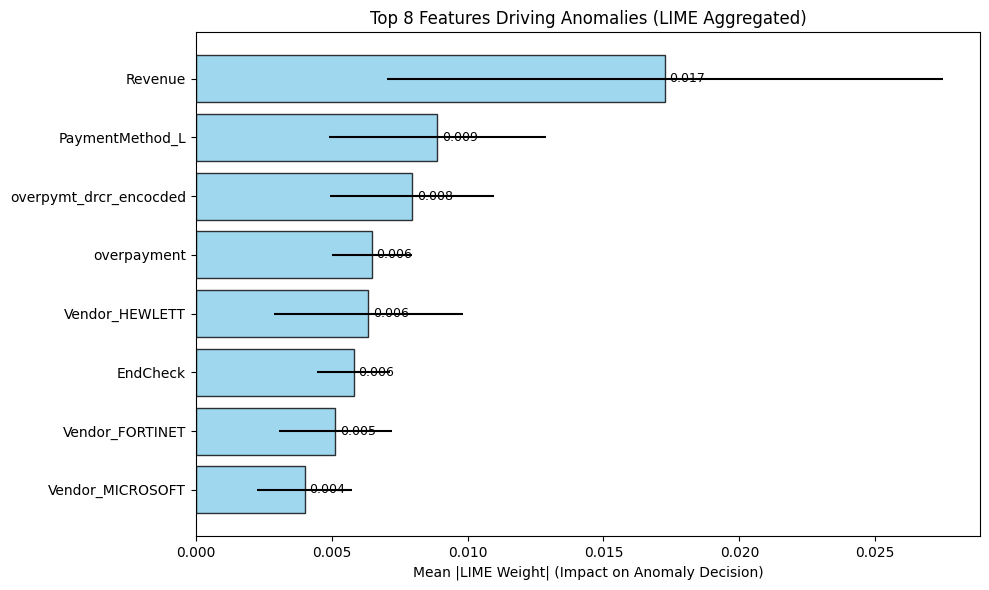

                        mean_abs_contribution   std_dev  frequency
feature                                                           
Revenue                              0.017250  0.010231          3
PaymentMethod_L                      0.008882  0.003996          3
overpymt_drcr_encocded               0.007965  0.003022          3
overpayment                          0.006471  0.001472          3
Vendor_HEWLETT                       0.006347  0.003473          3
EndCheck                             0.005814  0.001345          3
Vendor_FORTINET                      0.005130  0.002072          3
Vendor_MICROSOFT                     0.004002  0.001734          3
Vendor_SCHNEIDER                     0.003768  0.001799          3
OtherCheck                           0.003600  0.001957          3


In [91]:
# Run LIME analysis
lime_explanations = explain_anomalies_with_lime(
    iso_forest_model=results['model'],
    data=df_numeric,
    anomaly_indices=results['anomaly_indices'],
    num_samples=3
)

# Plot explanations
# plot_lime_explanations(lime_explanations, df_numeric)

# Get global importance
lime_global_imp = lime_global_feature_importance(lime_explanations)

# Plot
plot_lime_global_importance(lime_global_imp, top_n=8)

# View top features
print(lime_global_imp.head(10))

### SHAP

In [92]:
import shap

def explain_anomalies_with_shap(
    iso_forest_model,
    data: pd.DataFrame,
    anomaly_indices: np.ndarray,
    num_samples: int = 5
) -> dict:
    """
    Use SHAP to explain anomaly predictions from Isolation Forest.
    
    Parameters:
    -----------
    iso_forest_model : IsolationForest
        Trained IsolationForest model
    data : pd.DataFrame
        Original input data
    anomaly_indices : array
        Indices of anomalies
    num_samples : int
        Number of top anomalies to explain

    Returns:
    -------
    dict: Contains SHAP values and explainer object
    """
    # Use TreeExplainer for IsolationForest (since it's tree-based)
    explainer = shap.TreeExplainer(
        iso_forest_model,
        data.sample(min(100, len(data))),  # background data
        feature_perturbation="interventional",
        model_output='raw'  # outputs anomaly score
    )

    # Compute SHAP values for anomaly samples
    top_idx = anomaly_indices[:num_samples]
    X_sample = data.iloc[top_idx]

    shap_values = explainer.shap_values(X_sample)

    return {
        'shap_values': shap_values,
        'shap_explainer': explainer,
        'sample_data': X_sample,
        'anomaly_indices': top_idx,
        'expected_value': explainer.expected_value
    }

In [93]:
def plot_shap_explanations(shap_results: dict, data: pd.DataFrame):
    """
    Plot SHAP explanations for top anomalies.
    
    Parameters:
    -----------
    shap_results : dict
        Output from explain_anomalies_with_shap
    data : pd.DataFrame
        Original data
    """
    import matplotlib.pyplot as plt

    shap_values = shap_results['shap_values']
    sample_data = shap_results['sample_data']
    indices = shap_results['anomaly_indices']

    for i, idx in enumerate(indices):
        plt.figure(figsize=(10, 0.5 + 0.3 * len(sample_data.columns)))
        shap.waterfall_plot(
            shap.Explanation(
                values=shap_values[i],
                base_values=shap_results['expected_value'],
                data=sample_data.iloc[i].values,
                feature_names=sample_data.columns
            ),
            max_display=len(sample_data.columns),
            show=False
        )
        plt.title(f"SHAP Waterfall: Sample {idx} (AccDocNo: {data.index[idx]})")
        plt.tight_layout()
        plt.show()

def plot_shap_summary(shap_results: dict):
    """
    Global SHAP summary plot: which features drive anomalies overall?
    """
    import matplotlib.pyplot as plt

    shap_values = shap_results['shap_values']
    sample_data = shap_results['sample_data']

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, sample_data, show=False)
    plt.title("SHAP Summary: Feature Impact on Anomaly Score")
    plt.tight_layout()
    plt.show()

In [94]:
def shap_global_feature_importance(shap_results: dict) -> pd.DataFrame:
    """
    Compute global feature importance from SHAP values.
    
    Parameters:
    -----------
    shap_results : dict
        Output from explain_anomalies_with_shap()
    
    Returns:
    --------
    pd.DataFrame: Features ranked by mean absolute SHAP value
    """
    shap_values = shap_results['shap_values']  # Shape: (n_samples, n_features)
    feature_names = shap_results['sample_data'].columns

    # Mean absolute SHAP value per feature
    mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
    
    global_importance = pd.DataFrame({
        'feature': feature_names,
        'mean_abs_shap': mean_abs_shap
    }).sort_values(by='mean_abs_shap', ascending=False).reset_index(drop=True)

    return global_importance

In [95]:
def plot_shap_global_importance(shap_results: dict, top_n: int = 10):
    """
    Plot global SHAP feature importance.
    """
    import matplotlib.pyplot as plt

    shap_values = shap_results['shap_values']
    feature_names = shap_results['sample_data'].columns

    # Built-in SHAP summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values,
        shap_results['sample_data'],
        plot_type="bar",
        max_display=top_n,
        show=False
    )
    plt.title(f"SHAP Global Feature Importance (Top {top_n})")
    plt.tight_layout()
    plt.show()

D:\victoriaquek\AppData\Local\Temp\9\ipykernel_42124\357154899.py:44: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, sample_data, show=False)


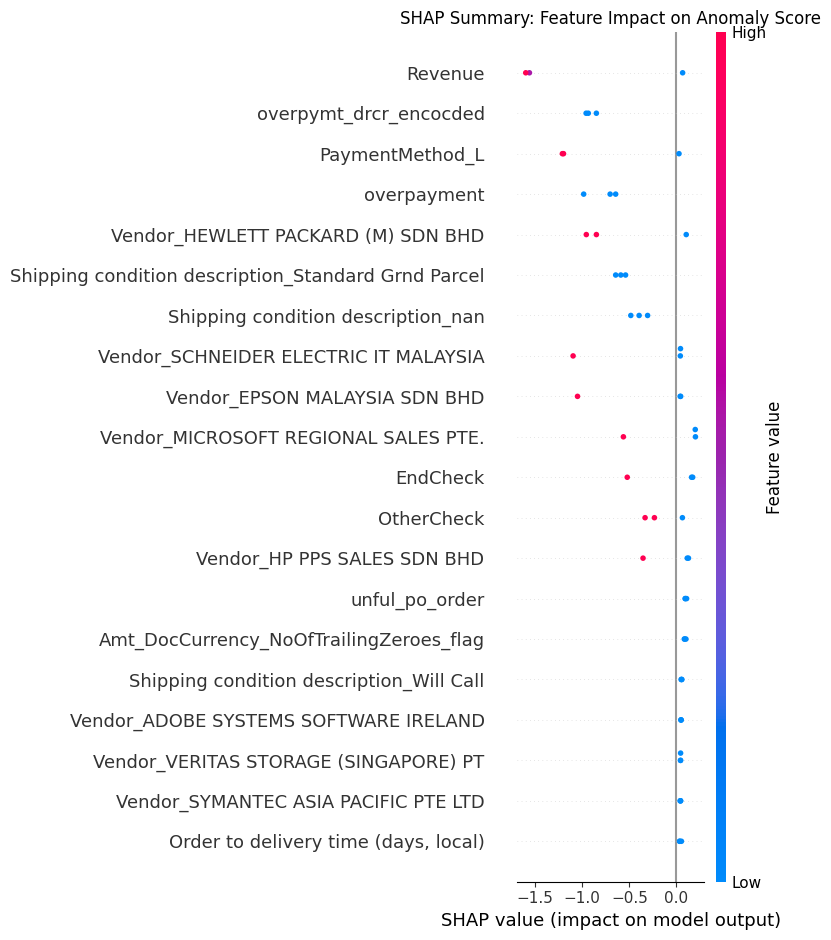

D:\victoriaquek\AppData\Local\Temp\9\ipykernel_42124\1876815382.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


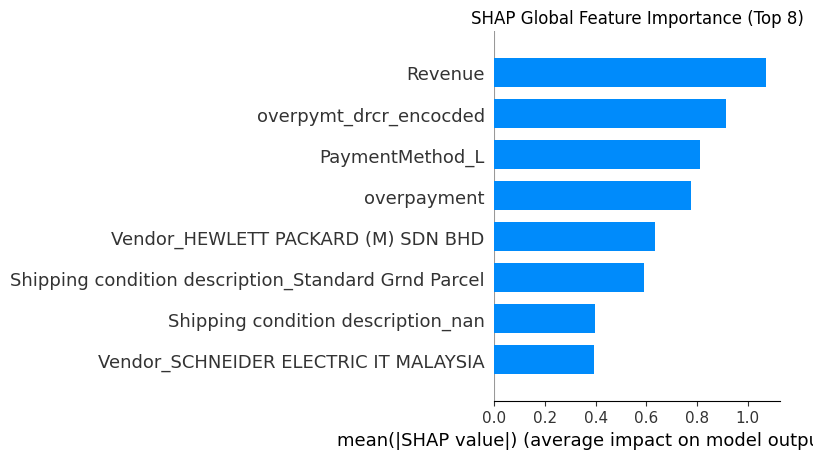

                                             feature  mean_abs_shap
0                                            Revenue       1.074265
1                             overpymt_drcr_encocded       0.914305
2                                    PaymentMethod_L       0.811508
3                                        overpayment       0.777613
4                 Vendor_HEWLETT PACKARD (M) SDN BHD       0.636277
5  Shipping condition description_Standard Grnd P...       0.591777
6                 Shipping condition description_nan       0.395617
7              Vendor_SCHNEIDER ELECTRIC IT MALAYSIA       0.393250
8                      Vendor_EPSON MALAYSIA SDN BHD       0.377617
9               Vendor_MICROSOFT REGIONAL SALES PTE.       0.320986


In [96]:
# Run SHAP analysis
shap_results = explain_anomalies_with_shap(
    iso_forest_model=results['model'],
    data=df_numeric,
    anomaly_indices=results['anomaly_indices'],
    num_samples=3
)

# Plot per-sample waterfall plots
# plot_shap_explanations(shap_results, df_numeric)

# Plot global feature importance
plot_shap_summary(shap_results)

# Get global importance
shap_global_imp = shap_global_feature_importance(shap_results)

# Plot
plot_shap_global_importance(shap_results, top_n=8)

# View top features
print(shap_global_imp.head(10))

### Comparing

In [97]:
def shap_global_feature_importance(shap_results: dict) -> pd.DataFrame:
    """
    Compute global feature importance from SHAP values.
    
    Parameters:
    -----------
    shap_results : dict
        Output from explain_anomalies_with_shap()
    
    Returns:
    --------
    pd.DataFrame: Features ranked by mean absolute SHAP value (with 'feature' column)
    """
    shap_values = shap_results['shap_values']  # Shape: (n_samples, n_features)
    
    # Ensure feature_names is a list
    feature_names = shap_results['sample_data'].columns.tolist()

    # Mean absolute SHAP value per feature
    mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
    
    # Explicitly create DataFrame with 'feature' column
    global_importance = pd.DataFrame({
        'feature': feature_names,
        'mean_abs_shap': mean_abs_shap
    }).sort_values(by='mean_abs_shap', ascending=False).reset_index(drop=True)

    return global_importance

def lime_global_feature_importance(lime_explanations: dict) -> pd.DataFrame:
    feature_contributions = []

    for idx, exp_data in lime_explanations.items():
        exp = exp_data['explanation']
        lime_list = exp.as_list(label=0)  # label 0 = anomaly
        
        for feature, weight in lime_list:
            base_feature = feature.split(" ")[0]  # Extract base feature name
            feature_contributions.append({
                'feature': base_feature,
                'abs_contribution': abs(weight),
                'contribution': weight
            })
    
    contrib_df = pd.DataFrame(feature_contributions)
    
    global_importance = (
        contrib_df.groupby('feature')['abs_contribution']
        .agg('mean')
        .rename('mean_abs_contribution')
        .sort_values(ascending=False)
        .reset_index()
    )
    
    return global_importance  # Now definitely has 'feature' column

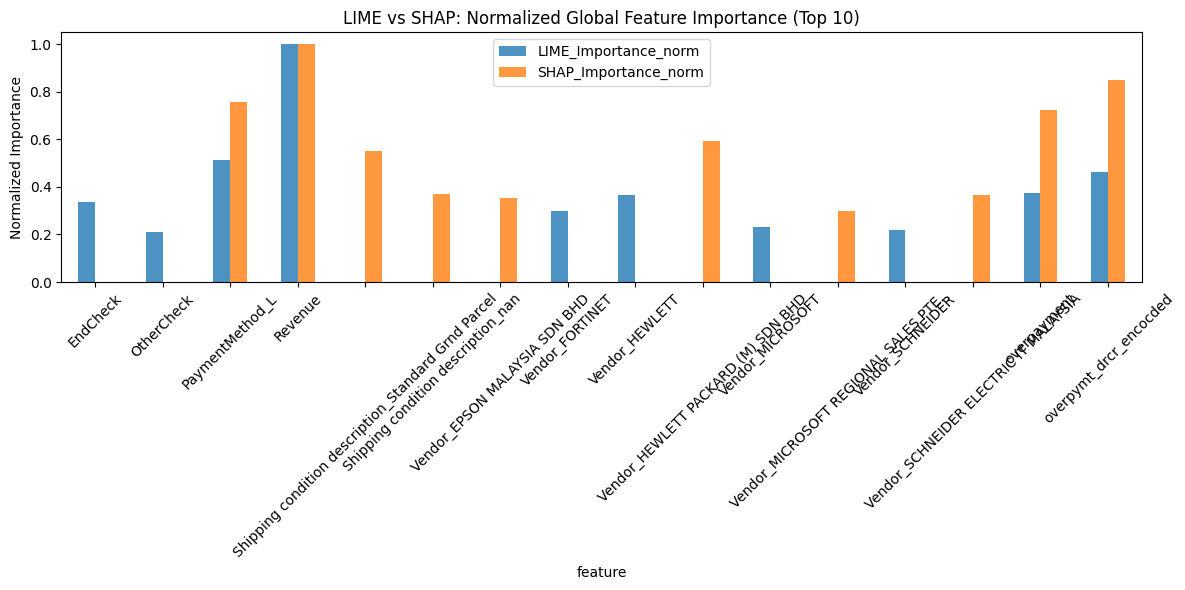

In [98]:
# Get both importances
lime_global_imp = lime_global_feature_importance(lime_explanations)
shap_global_imp = shap_global_feature_importance(shap_results)

# Merge safely
comparison = pd.merge(
    lime_global_imp[['feature', 'mean_abs_contribution']].head(10),
    shap_global_imp[['feature', 'mean_abs_shap']].head(10),
    on='feature',
    how='outer'
).fillna(0)

# Rename for clarity
comparison = comparison.rename(columns={
    'mean_abs_contribution': 'LIME_Importance',
    'mean_abs_shap': 'SHAP_Importance'
})

# Optional: Normalize to 0–1 for fair visual comparison
for col in ['LIME_Importance', 'SHAP_Importance']:
    if comparison[col].max() > 0:
        comparison[col + '_norm'] = comparison[col] / comparison[col].max()

# Plot normalized comparison
comparison.set_index('feature')[['LIME_Importance_norm', 'SHAP_Importance_norm']].plot(
    kind='bar', figsize=(12, 6), alpha=0.8
)
plt.title("LIME vs SHAP: Normalized Global Feature Importance (Top 10)")
plt.ylabel("Normalized Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [99]:
print("LIME columns:", lime_global_imp.columns.tolist())
print("SHAP columns:", shap_global_imp.columns.tolist())
print("LIME sample:\n", lime_global_imp.head())
print("SHAP sample:\n", shap_global_imp.head())

LIME columns: ['feature', 'mean_abs_contribution']
SHAP columns: ['feature', 'mean_abs_shap']
LIME sample:
                   feature  mean_abs_contribution
0                 Revenue               0.017250
1         PaymentMethod_L               0.008882
2  overpymt_drcr_encocded               0.007965
3             overpayment               0.006471
4          Vendor_HEWLETT               0.006347
SHAP sample:
                               feature  mean_abs_shap
0                             Revenue       1.074265
1              overpymt_drcr_encocded       0.914305
2                     PaymentMethod_L       0.811508
3                         overpayment       0.777613
4  Vendor_HEWLETT PACKARD (M) SDN BHD       0.636277


# PCA

In [109]:
# Step 1: Standardize the numeric data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(df_num)

# Step 2: Apply PCA
pca = PCA(n_components=0.95)  # Adjust n_components as needed

X_pca = pca.fit_transform(df_numeric)

# Step 3: Reconstruct from PCA space
X_reconstructed = pca.inverse_transform(X_pca)

# Step 4: Compute reconstruction error
reconstruction_errors = np.mean((df_numeric - X_reconstructed) ** 2, axis=1)

# Step 5: Set threshold (e.g., 99th percentile)
threshold = np.percentile(reconstruction_errors, 99)
anomalies_mask = reconstruction_errors > threshold

# Step 6: Add info back to original DataFrame
all_outliers = df_result.copy()  # Work on a copy

# Add reconstruction error and global anomaly flag
all_outliers['reconstruction_error'] = reconstruction_errors
all_outliers['is_anomaly'] = anomalies_mask.astype(int)


# === NEW: Identify primary contributing feature and direction ===

# Get absolute reconstruction error per feature (unscaled differences don't help; we want meaningful contribution)
# Since PCA operates on scaled data, use scaled values for comparison
# abs_reconstruction_diff = np.abs(X_scaled - X_reconstructed_scaled)  # [n_samples, n_features]
abs_reconstruction_diff = np.abs(df_numeric.values - X_reconstructed)  # [n_samples, n_features]

# Find the feature with the maximum absolute error for each sample
max_error_indices = np.argmax(abs_reconstruction_diff, axis=1)  # Index of worst feature per row

# Map index back to feature name
feature_names = df_numeric.columns.tolist()
all_outliers['primary_anomalous_feature'] = [feature_names[idx] for idx in max_error_indices]

# Determine direction: original scaled value > reconstructed (too high), else too low
directions = []
for i in range(len(df_numeric)):
    primary_feat_idx = max_error_indices[i]
    if df_numeric.iloc[i, primary_feat_idx] > X_reconstructed[i, primary_feat_idx]:
        directions.append("too high")
    else:
        directions.append("too low")

all_outliers['anomaly_direction'] = directions

In [110]:
# Number of outliers
print(f'Number of outliers: {all_outliers[all_outliers['is_anomaly'] == 1].shape[0]}')

Number of outliers: 302


In [111]:
all_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35779 entries, 0 to 35778
Data columns (total 88 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   FiscalYear                                  35779 non-null  int64         
 1   AccDocNo                                    35779 non-null  int64         
 2   Dr_Cr                                       35779 non-null  object        
 3   DateOfAccDocEntry                           35779 non-null  object        
 4   DateOfAccDocEntry_and_TimeOfEntry (MYT)     35779 non-null  object        
 5   NoOfLineItemInAccDoc                        35779 non-null  object        
 6   RefKeyForLineItem                           35779 non-null  object        
 7   GL_DESCRIPTION                              35779 non-null  object        
 8   Amt_localCurrencyFormatted                  35779 non-null  object        
 9   Docume

In [112]:
all_outliers.to_excel(rf"D:\victoriaquek\JE ML 2025\Results\siewpl_zros_pca.xlsx")

## Explaining

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume you've already done:
#   X_pca = pca.fit_transform(df_numeric)
#   X_reconstructed = pca.inverse_transform(X_pca)
#   reconstruction_errors = np.mean((df_numeric - X_reconstructed) ** 2, axis=1)
#   threshold = np.percentile(reconstruction_errors, 99)
#   anomalies_mask = reconstruction_errors > threshold

# -------------------------------
# Step: Analyze Feature Contributions to Anomalies
# -------------------------------

# Convert to DataFrame for easier handling
df_numeric = df_numeric.reset_index(drop=True)  # Ensure clean index
X_reconstructed_df = pd.DataFrame(X_reconstructed, columns=df_numeric.columns, index=df_numeric.index)

# Compute per-feature squared error
per_feature_squared_error = (df_numeric - X_reconstructed_df) ** 2  # (original - recon)^2

# But we want direction too: was the original value higher or lower?
per_feature_residual = df_numeric - X_reconstructed_df  # Positive = original > recon

# Optional: Normalize by feature variance (more meaningful comparison)
# This turns residuals into "number of std deviations off"
feature_std = df_numeric.std()
# Avoid division by zero
feature_std = feature_std.where(feature_std != 0, 1)  # prevent inf
normalized_residuals = per_feature_residual / feature_std  # z-scored residual

# Rank features by absolute normalized residual
abs_normalized_residuals = normalized_residuals.abs()

# Now, identify top contributing features for each anomaly
def explain_anomaly(row_idx, top_n=3):
    """Return top features that contributed most to anomaly, with direction."""
    row_contrib = abs_normalized_residuals.loc[row_idx]
    top_features = row_contrib.nlargest(top_n).index
    explanation = []
    for feat in top_features:
        direction = "too HIGH" if per_feature_residual.loc[row_idx, feat] > 0 else "too LOW"
        z_score = normalized_residuals.loc[row_idx, feat]
        explanation.append({
            'feature': feat,
            'value': df_numeric.loc[row_idx, feat],
            'reconstructed': X_reconstructed_df.loc[row_idx, feat],
            'z_residual': z_score,
            'direction': direction
        })
    return explanation

# Apply to all anomalies
anomaly_explanations = []
for idx in df_numeric[anomalies_mask].index:
    explanation = explain_anomaly(idx, top_n=3)
    for e in explanation:
        e['AccDocNo'] = all_outliers.loc[idx, 'AccDocNo']  # assuming AccDocNo exists
        e['reconstruction_error'] = reconstruction_errors[idx]
        anomaly_explanations.append(e)

# Create a DataFrame of explanations
explanation_df = pd.DataFrame(anomaly_explanations)

# Optional: Sort by z_residual to see most extreme deviations overall
explanation_df = explanation_df.sort_values(by='z_residual', ascending=False)
explanation_df

In [ ]:
# Top N most frequently implicated features
top_impact_features = explanation_df['feature'].value_counts().head(10)

plt.figure(figsize=(10, 6))
top_impact_features.plot(kind='barh')
plt.title("Top Features Contributing to Anomalies")
plt.xlabel("Number of Times Top Contributor to Anomaly")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Save

In [ ]:
table_name="siewpl_zros_iso"
sub_df= result_df.head(5).copy()
try:
    sql_db.fn_create_new_table_from_df(table_name=table_name, df=sub_df, auto_data_type=True)
    res=sql_db.fn_append_df_to_table(table_name=table_name, df=sub_df)
    print(res)
except Exception as e:
    # result_df.to_excel(rf"D:\victoriaquek\JE ML 2025\Results\siewpl_zros_iso.xlsx")
    print(e)

In [ ]:
# all_outliers.to_excel(rf"D:\victoriaquek\JE ML 2025\Results\siewpl_zotc_pca.xlsx")